In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import _utils_extract_sources_in_cosmoDC2
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql

from mysql.connector import Error
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

## Cosmodc2 with qserv & GCRCatalogs

In [2]:
z, ra, dec = .01, 65, -40

### true shapes, true redshifts

In [3]:
def query(lens_z, lens_distance, ra, dec, rmax = 10):
    r"""
    Attributes:
    -----------
    z: float
        lens redshift
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0.0
    theta_max = (rmax/lens_distance) * (180./np.pi)
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, "
    query += "data.mag_u, data.mag_g, data.mag_r, data.mag_i, data.mag_z, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true_uncorr, data.ellipticity_2_true as e2_true_uncorr " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 28 "
    query += ";" 
    return query

In [4]:
rmax=.1
bckgd_galaxy_catalog = _utils_extract_sources_in_cosmoDC2.extract(lens_redshift=None,
                                                qserv_query=query(z, cosmo.eval_da(z), ra, dec, rmax = rmax), conn_qserv=conn,
                                               cosmo=cosmo)

/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/extract_DC2_data/_utils_extract_sources_in_cosmoDC2.py:107: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tab = pd.read_sql_query(query_mysql, conn_qserv)


In [5]:
theta_arcmin = 3437.75*(rmax/cosmo.eval_da_z1z2(0, z))
S_arcmin2 =np.pi*theta_arcmin**2

/tmp/ipykernel_36372/3104529618.py:44: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  plt.hist(x,weights=(np.zeros(len(x))+1)/S_arcmin2, histtype='step', bins=bins, lw=2, color = 'b', ls='-', label = r'DES-like $r < 28$', hatch=' \ ')


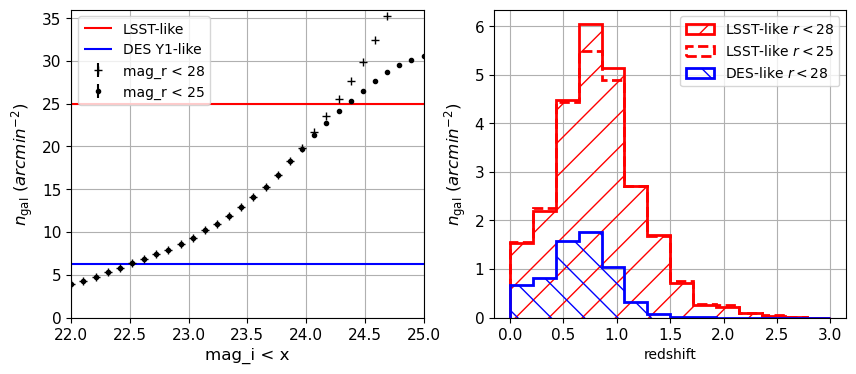

In [19]:
mag_i_max=np.linspace(22, 25, 30)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hlines(25, mag_i_max[0], mag_i_max[-1], color='r', label='LSST-like')
plt.hlines(6.28, mag_i_max[0], mag_i_max[-1], color='b', label='DES Y1-like')
for i,mag_i_min_ in enumerate(mag_i_max):
    mask=(bckgd_galaxy_catalog['mag_i'] < mag_i_min_)
    mask = mask * (bckgd_galaxy_catalog['mag_r'] < 28) * (bckgd_galaxy_catalog['z'] < 3)*(bckgd_galaxy_catalog['z'] >0)
    n_gal_arcmin2=len(bckgd_galaxy_catalog[mask])/S_arcmin2
    err_n_gal_arcmin2 = len(bckgd_galaxy_catalog[mask])**.5/S_arcmin2
    plt.errorbar(mag_i_min_, n_gal_arcmin2 , linestyle='none', marker = '+', color='k')
    
    mask=(bckgd_galaxy_catalog['mag_i'] < mag_i_min_)
    mask = mask * (bckgd_galaxy_catalog['mag_r'] < 25) * (bckgd_galaxy_catalog['z'] < 3)*(bckgd_galaxy_catalog['z'] >0)
    n_gal_arcmin2=len(bckgd_galaxy_catalog[mask])/S_arcmin2
    err_n_gal_arcmin2 = len(bckgd_galaxy_catalog[mask])**.5/S_arcmin2
    plt.errorbar(mag_i_min_, n_gal_arcmin2 , linestyle='none', marker = '.', color='k')
    
plt.errorbar([], [],1, marker = '+', color = 'k', fmt = ' ', label = 'mag_r < 28')
plt.errorbar([], [],1, marker = '.', color = 'k', fmt = ' ',label = 'mag_r < 25')
plt.xlabel(r'mag_i < x', fontsize=12)
plt.grid(True)
plt.ylim(0, 36)
plt.plot
plt.ylabel(r'$n_{\rm gal}$ $(arcmin^{-2})$', fontsize=12)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.legend()
plt.xlim(mag_i_max[0], mag_i_max[-1])
bins=np.linspace(16, 30, 30)
plt.subplot(122)
mask_LSST_r28 = (bckgd_galaxy_catalog['mag_i'] < 24.2)*(bckgd_galaxy_catalog['mag_r'] < 28)
mask_HSC = (bckgd_galaxy_catalog['mag_i'] < 24.4)*(bckgd_galaxy_catalog['mag_r'] < 28)
mask_DES = (bckgd_galaxy_catalog['mag_i'] < 22.3)*(bckgd_galaxy_catalog['mag_r'] < 28)
bins=np.linspace(0, 3, 15)    
mask_LSST_r28 = (bckgd_galaxy_catalog['mag_i'] < 24.25)*(bckgd_galaxy_catalog['mag_r'] < 28)
x = bckgd_galaxy_catalog['z'][mask_LSST_r28]
plt.hist(x,weights=(np.zeros(len(x))+1)/S_arcmin2, histtype='step', bins=bins, lw=2, color = 'r', ls='-',label = r'LSST-like $r < 28$', hatch='/')
mask_LSST_r25 = (bckgd_galaxy_catalog['mag_i'] < 24.3)*(bckgd_galaxy_catalog['mag_r'] < 25)
x = bckgd_galaxy_catalog['z'][mask_LSST_r25]
plt.hist(x,weights=(np.zeros(len(x))+1)/S_arcmin2, histtype='step', bins=bins, lw=2, color = 'r', ls='--', label = r'LSST-like $r < 25$')

mask_DES_r28 = (bckgd_galaxy_catalog['mag_i'] < 22.5)*(bckgd_galaxy_catalog['mag_r'] < 28)
x=bckgd_galaxy_catalog['z'][mask_DES_r28]
plt.hist(x,weights=(np.zeros(len(x))+1)/S_arcmin2, histtype='step', bins=bins, lw=2, color = 'b', ls='-', label = r'DES-like $r < 28$', hatch=' \ ')
plt.xlabel('redshift')
plt.ylabel(r'$n_{\rm gal}$ $(arcmin^{-2})$', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig('../fig/galaxy_density_cut.png', bbox_inches='tight', dpi=300)

In [7]:
np.std(bckgd_galaxy_catalog['e1_true_uncorr'])

0.16965923599097188